<font size="6"> **Rule-Based Sentiment Factors in SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import pprint

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [5]:
cfg = utils.read_conf()

In [6]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [7]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'tenks_risk_tfidf_by_sent.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 =  'tenks_risk_doc_len.csv'
INFILE5 = cfg['quantopian']['dataset4']['prices']
INFILE6 = cfg['output']['interim']['sector_factors']

In [8]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [9]:
OUTFILE1 = 'sec_10k_loughran_sent_alpha.csv'

In [10]:
example_ticker = 'amzn'

# Load Data

In [11]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [12]:
tf_idf_by_sent = bow_sent.read_sent_tfidf_dict(path=INPATH1, name=INFILE2)

In [13]:
tf_idf_by_sent.keys()

dict_keys(['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])

In [14]:
tf_idf_by_sent['negative'].iloc[0:2,0:10]

abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                   
aal    2003-04-15      0.0          0.0           0.0       0.0         0.0   
       2004-02-27      0.0          0.0           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-04-15          0.0       0.0         0.0           0.0   
       2004-02-27          0.0       0.0         0.0           0.0   

                   aberrations  
ticker date                     
aal    2003-04-15          0.0  
       2004-02-27          0.0

In [15]:
tf_idf_by_sent['negative'].iloc[:5,0]  # underlying pandas is an sparse data structure

ticker  date      
aal     2003-04-15    0.0
        2004-02-27    0.0
        2005-02-25    0.0
        2006-02-24    0.0
        2007-02-23    0.0
Name: abandon, dtype: Sparse[float64, 0.0]

In [16]:
doc_lens = pd.read_csv(INPATH1 + INFILE4, parse_dates=['date'], index_col=[0,1])['doc_len']

In [17]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

In [18]:
# Yearly pricing
pricing = pd.read_csv(INPATH2 + INFILE5, parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')
pricing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [19]:
pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [20]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [21]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [22]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE6, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [23]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
asset,,
A,0,Healthcare
AAL,3,Industrials
HPE,1,Technology
CSRA,1,Technology


# Rule Based Sentiment Analysis: Loughran Mcdonald textual analysis in financial data

Leverage expert crafted sentiments word lists to analyze create alpha factors. Two approaches:

* For a given ticker's 10k's document, measure evolution at each sentiment by computing similiarity among doc[t] and doc[t+1]
* Compute a sentiment score based on frequencies of each sentiment word list on each ticker 10k. Then standardize scores to obtain an alpha factor by each document



Referene: https://sraf.nd.edu/textual-analysis/resources/

In [24]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [25]:
sentiment_df[sentiments].sum(axis=0)

negative        1515
positive         249
uncertainty      230
litigious        716
constraining      96
interesting       60
dtype: int64

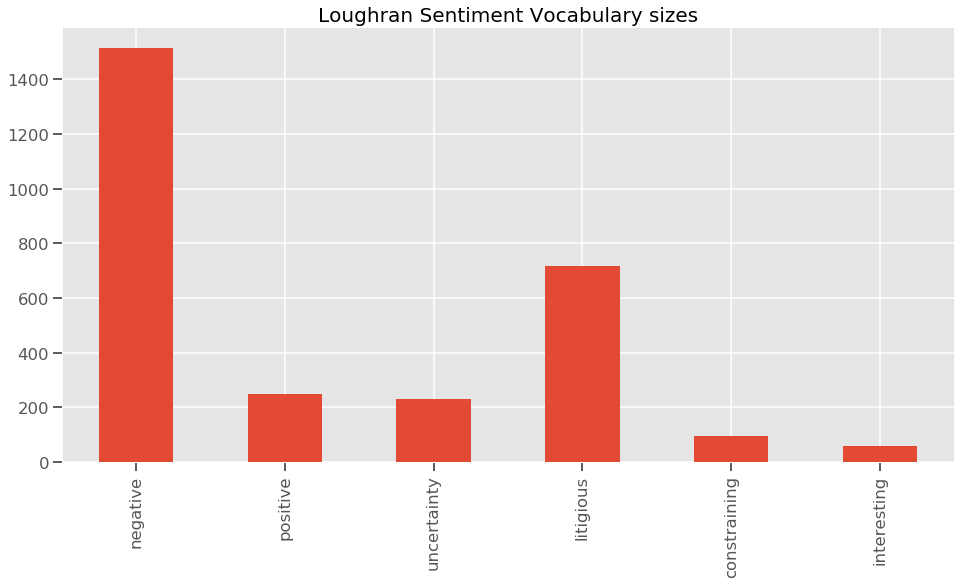

In [26]:
sent_vocab_sizes = sentiment_df[sentiments].sum(axis=0)
sent_vocab_sizes.plot.bar(title='Loughran Sentiment Vocabulary sizes')
plt.show()

## Sentiment Scores

Firstly, aggregate tf-idf scores for each doc-sentiment (on each date). As sentiment vocabulary is considerabily varies, perform a zscore on date axis, that's it, by aggregating on each date each sentiment score

In [27]:
#['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])
sent_score_sign = {'negative': -1,
                'uncertainty': -1,
                'litigious': -1,
                'constraining': -1,
                'positive': +1,
                'interesting': +1}
# Assumpmtion: Negative sentiments are asigned a negative raw alpha value,
# however, as they are then zscored, it is assumed that low z-scored values yield positive forward returns
# and high z-score values greater than zero ones

In [28]:
sent_score_dfs =  {}

for sent_key, tfidf_mat in tf_idf_by_sent.items():  #.div(doc_lens)
    sent_raw_score = tfidf_mat.sum(axis=1)  # * sent_score_sign[sent_key] # sentiment raw score by ticker-date
    sent_raw_score.name = 'sentiment_score'
    sent_score_dfs[sent_key] = sent_raw_score

### Analyze sentiment score distribution

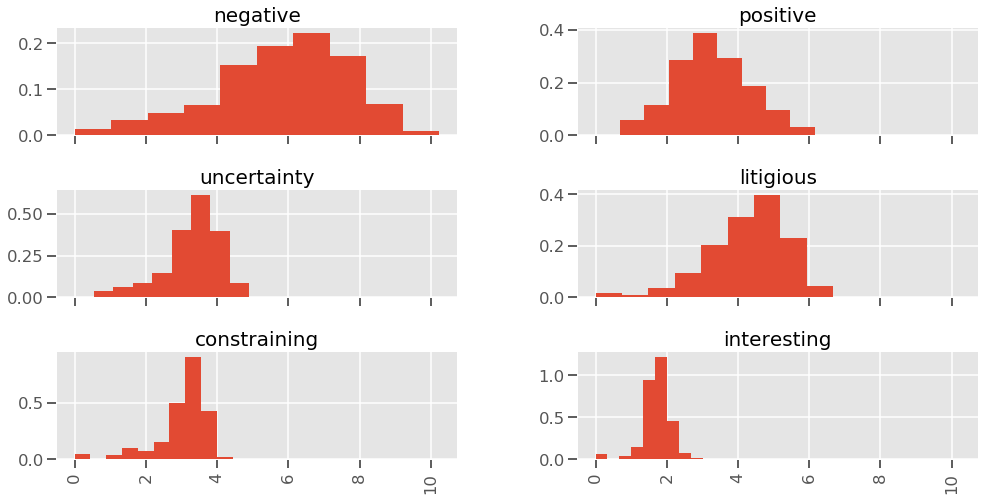

In [29]:
sent_by_score = pd.concat(sent_score_dfs).to_frame()
sent_by_score.index.set_names(inplace=True, names='sentiment', level=0)
sent_by_score.hist(by='sentiment', sharex=True, density=True)
plt.show()

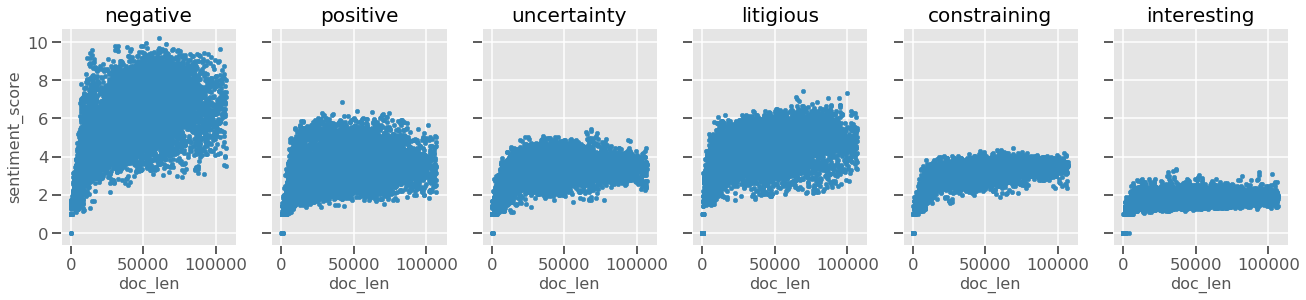

In [30]:
fig, axs = plt.subplots(1,len(sentiments), sharex=True, sharey=True, figsize=(22, 4))

for i, sentiment in enumerate(sentiments):
    join_data = sent_score_dfs[sentiment].to_frame().join(doc_lens[doc_lens<doc_lens.quantile(0.95)])
    ax = axs[i]
    join_data.plot.scatter(x='doc_len', y='sentiment_score', ax=ax)
    ax.set_title(sentiment)

Bigger documents does not skew sentiment scores to larger values, therefore it is not necesary to scale by doc length

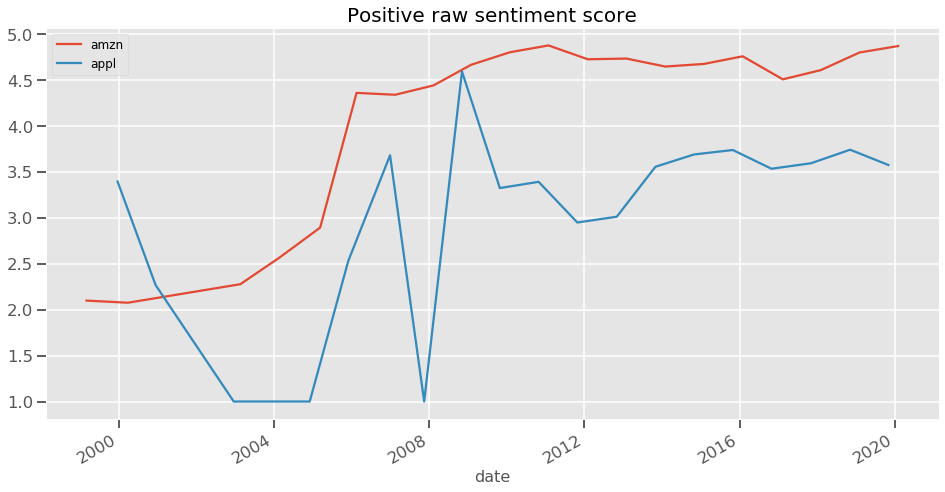

In [31]:
sent_score_dfs['positive'][example_ticker].plot(title='Positive raw sentiment score', label='amzn')
sent_score_dfs['positive']['aapl'].plot(label='appl')
plt.legend()
plt.show()

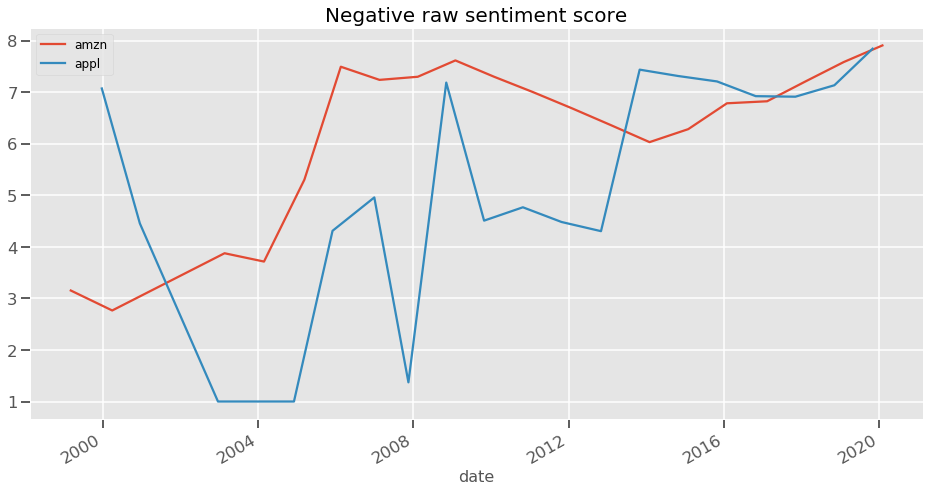

In [32]:
sent_score_dfs['negative'][example_ticker].plot(title='Negative raw sentiment score', label='amzn')
sent_score_dfs['negative']['aapl'].plot(label='appl')
plt.legend()
plt.show()

### Compute Alpha-Factor

Negative sentiments values should be multiplied by -1 to invert relationship direction

In [33]:
sent_alphas_raw = pd.concat(sent_score_dfs)
sent_alphas_raw.index.rename(inplace=True, level=0, names='sentiment')
sent_alphas_raw = sent_alphas_raw.reset_index()
sent_alphas_raw['idx_year'] = sent_alphas_raw['date'].dt.year
sent_alphas_raw['asset'] = [ticker.upper() for ticker in sent_alphas_raw['ticker']]

sent_alphas_raw = sent_alphas_raw.merge(sector_to_asset, how='left', left_on='asset', right_on='asset').set_index(['sentiment', 'ticker', 'date'])
sent_alphas_raw['sector_code'] = sent_alphas_raw['sector_code'].fillna(-1)
sent_alphas_raw['sector'] = sent_alphas_raw['sector'].fillna('No sector')

sent_alphas_raw.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51822 entries, ('negative', 'aal', Timestamp('2003-04-15 00:00:00')) to ('interesting', 'zts', Timestamp('2020-02-13 00:00:00'))
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  51822 non-null  float64
 1   idx_year         51822 non-null  int64  
 2   asset            51822 non-null  object 
 3   sector_code      51822 non-null  int64  
 4   sector           51822 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


In [34]:
pd.concat([sent_alphas_raw.head(2), sent_alphas_raw.tail(2)], axis=0)

sentiment_score  idx_year asset  sector_code  \
sentiment   ticker date                                                       
negative    aal    2003-04-15         4.127286      2003   AAL            3   
                   2004-02-27         3.560158      2004   AAL            3   
interesting zts    2019-02-14         1.851533      2019   ZTS            0   
                   2020-02-13         1.910821      2020   ZTS            0   

                                    sector  
sentiment   ticker date                     
negative    aal    2003-04-15  Industrials  
                   2004-02-27  Industrials  
interesting zts    2019-02-14   Healthcare  
                   2020-02-13   Healthcare

In [35]:
sent_alphas_count = sent_alphas_raw.groupby(['idx_year']).size()
#sent_alphas_count.name = 'count'
#sns.lineplot(data=sent_alphas_count.reset_index().drop_duplicates(), x='idx_year', y='count')
#plt.title('Total number of documents by year (ticker-date)')
#plt.show()

In [36]:
sent_alphas = pd.DataFrame(index=sent_score_dfs[sentiments[0]].index, columns=sentiments, dtype=float)
for sentiment in sentiments:
    sent_alphas[sentiment] = bow_sent.compute_sentiment_alpha_factor(
        sent_scores=sent_alphas_raw.loc[sentiment], date_col='idx_year',
        sector_col='sector_code', score_col='sentiment_score'
    ) * sent_score_sign[sentiment]


In [37]:
pd.concat([sent_alphas.head(2), sent_alphas.tail(2)], axis=0)

negative  positive  uncertainty  litigious  constraining  \
ticker date                                                                   
aal    2003-04-15  0.156000 -0.550589     0.523059  -0.954354     -1.624239   
       2004-02-27  0.760193 -1.006005     0.696464  -0.268571     -1.042421   
zts    2019-02-14  0.784686 -1.389469    -0.799997  -0.218181      0.019139   
       2020-02-13  0.760003 -1.406636    -1.053927  -0.062984      0.314919   

                   interesting  
ticker date                     
aal    2003-04-15     1.486592  
       2004-02-27     1.260921  
zts    2019-02-14    -0.310047  
       2020-02-13    -0.205747

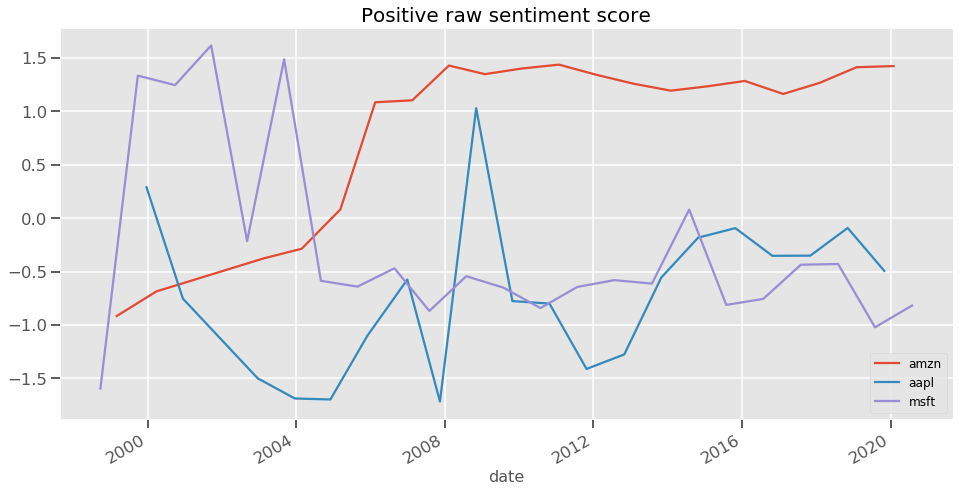

In [38]:
sent_alphas.loc[example_ticker, 'positive'].plot(title='Positive raw sentiment score', label='amzn')
sent_alphas.loc['aapl', 'positive'].plot(label='aapl')
sent_alphas.loc['msft', 'positive'].plot(label='msft')
plt.legend()
plt.show()

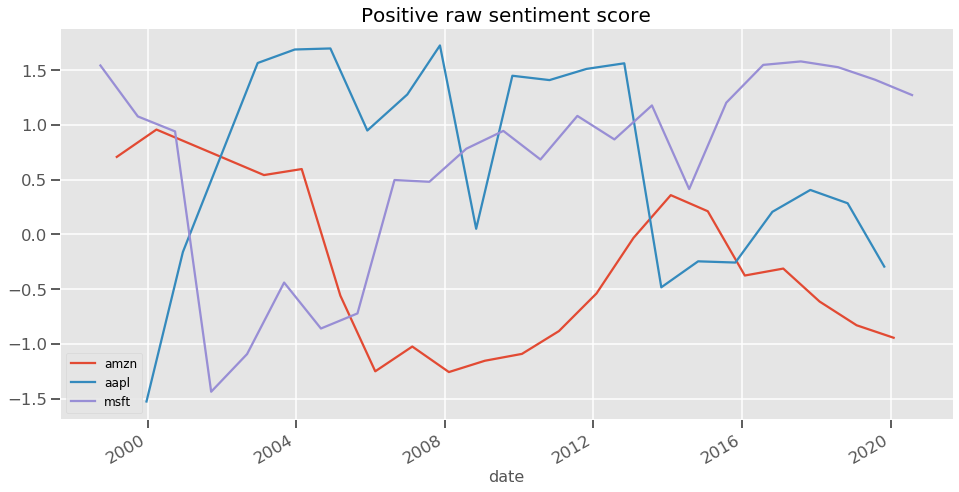

In [39]:
sent_alphas.loc[example_ticker, 'negative'].plot(title='Positive raw sentiment score', label='amzn')
sent_alphas.loc['aapl', 'negative'].plot(label='aapl')
sent_alphas.loc['msft', 'negative'].plot(label='msft')
plt.legend()
plt.show()

# Write Data

In [40]:
sent_alphas.to_csv(OUTPATH + OUTFILE1)